In [51]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Tuple
import warnings
import pmdarima as pm
warnings.filterwarnings("ignore")

In [103]:
# ==========================================
# 0. Core Configuration
# ==========================================
CSV_FILE = '/Users/haokun/Downloads/California weekly data.csv'
TARGET_COL = 'LAI'
LAGS = 12
SEQ_LENGTH = 12
TRAIN_END = '2018-12-31'
TEST_START = '2019-01-01'
EPOCHS = 100
BATCH_SIZE = 16
TUNE = True  # Set to True for the first run

In [104]:
# ==========================================
# 1. Helper Functions
# ==========================================

def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        xs.append(features[i:(i + seq_length)])
        ys.append(targets[i + seq_length])
    return np.array(xs), np.array(ys)

def create_lagged_features(df, target_col, lags):
    df = df.copy()
    if 'time' in df.columns: df = df.set_index('time').sort_index()
    cols = df.columns.tolist()
    for lag in range(1, lags + 1):
        for c in cols:
            df[f"{c}_lag_{lag}"] = df[c].shift(lag)
    df = df.dropna()
    X = df.drop(columns=[target_col]).values
    y = df[target_col].values
    return df, X, y


In [105]:
# ==========================================
# 2. Data Preparation
# ==========================================
df_raw = pd.read_csv(CSV_FILE, index_col='time', parse_dates=True).sort_index().dropna()
if 'level' in df_raw.columns: df_raw = df_raw.drop(columns=['level']) # remove constant column

# --- Lagged Data (RF / MLP) ---
df_lagged, X_all_lag, y_all_lag = create_lagged_features(df_raw.reset_index(), TARGET_COL, LAGS)
feature_names_lag = df_lagged.drop(columns=[TARGET_COL]).columns
lag_y_indices = [i for i, name in enumerate(feature_names_lag) if f"{TARGET_COL}_lag" in name]

train_mask = df_lagged.index <= TRAIN_END
test_mask = df_lagged.index >= TEST_START

X_train_lag, y_train_lag = X_all_lag[train_mask], y_all_lag[train_mask]
X_test_lag, y_test_lag = X_all_lag[test_mask], y_all_lag[test_mask]

scaler_X_lag = MinMaxScaler().fit(X_train_lag)
scaler_y = MinMaxScaler().fit(y_train_lag.reshape(-1, 1))

X_train_lag_sc = scaler_X_lag.transform(X_train_lag)
X_test_lag_sc = scaler_X_lag.transform(X_test_lag)
y_train_lag_sc = scaler_y.transform(y_train_lag.reshape(-1,1))
y_test_lag_sc = scaler_y.transform(y_test_lag.reshape(-1,1))

# --- Sequence Data (LSTM) ---
X_raw_exog = df_raw.drop(columns=[TARGET_COL]).values
scaler_X_raw = MinMaxScaler().fit(X_raw_exog[df_raw.index <= TRAIN_END])
X_raw_sc = scaler_X_raw.transform(X_raw_exog)
y_raw_sc = scaler_y.transform(df_raw[TARGET_COL].values.reshape(-1,1))

X_train_lstm, y_train_lstm = create_sequences(X_raw_sc[df_raw.index <= TRAIN_END], 
                                              y_raw_sc[df_raw.index <= TRAIN_END], SEQ_LENGTH)

# Sequence Generation
test_start_idx = np.where(df_raw.index >= TEST_START)[0][0]
X_test_ext = X_raw_sc[test_start_idx - SEQ_LENGTH : ]
y_test_ext = y_raw_sc[test_start_idx - SEQ_LENGTH : ]
X_test_lstm, _ = create_sequences(X_test_ext, y_test_ext, SEQ_LENGTH)

X_train_lstm_seq, y_train_lstm_seq = create_sequences(
    X_raw_sc[np.where(df_raw.index <= TRAIN_END)[0]], 
    y_raw_sc[np.where(df_raw.index <= TRAIN_END)[0]], SEQ_LENGTH)

# Tensors
X_train_t_lstm = torch.from_numpy(X_train_lstm_seq).float()
Y_train_t_lstm = torch.from_numpy(y_train_lstm_seq).float()
X_test_t_lstm = torch.from_numpy(X_test_lstm).float()
Y_test_t_lstm = torch.from_numpy(y_test_ext[SEQ_LENGTH:]).float() 


In [106]:
# ==========================================
# 3. Model Architectures
# ==========================================

class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])



In [107]:
# ==========================================
# 4. Recursive Forecasting Engine
# ==========================================

def recursive_forecast(model, model_type, start_idx, horizon, X_test_base, lag_y_idx, scaler_y):
    """Handles recursion logic for RF, MLP, and LSTM"""
    preds_raw = []
    
    if model_type in ['RF', 'MLP']:
        current_input = X_test_base[start_idx].copy()
        for h in range(horizon):
            if model_type == 'RF':
                p_raw = model.predict(current_input.reshape(1, -1))[0]
            else:
                model.eval()
                p_raw = model(torch.tensor(current_input, dtype=torch.float32).unsqueeze(0)).item()
                p_raw = scaler_y.inverse_transform([[p_raw]])[0][0]
            
            preds_raw.append(p_raw)
            if h < horizon - 1:
                next_input = X_test_base[start_idx + h + 1].copy()
                # Inject predictions into lags (SCALED)
                p_sc = scaler_y.transform([[p_raw]])[0][0]
                for lag_rank, idx in enumerate(lag_y_idx):
                    if len(preds_raw) >= (lag_rank + 1):
                        next_input[idx] = scaler_y.transform([[preds_raw[-(lag_rank+1)]]])[0][0]
                current_input = next_input

    elif model_type == 'LSTM':
        # Sequence logic
        current_seq = torch.tensor(X_test_lstm[start_idx], dtype=torch.float32).unsqueeze(0)
        for h in range(horizon):
            model.eval()
            p_sc = model(current_seq).item()
            preds_raw.append(scaler_y.inverse_transform([[p_sc]])[0][0])
            if h < horizon - 1:
                new_step_exog = torch.tensor(X_raw_sc[test_start_idx + start_idx + h + 1], dtype=torch.float32)
                current_seq = torch.roll(current_seq, shifts=-1, dims=1)
                current_seq[0, -1, :] = new_step_exog # Update with future exog features
                
    return preds_raw


In [64]:
# ==========================================
# 5. Training & Execution
# ==========================================

In [135]:
# 1. Random Forest Tuning
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

grid_search = RandomizedSearchCV(RandomForestRegressor(), 
                            param_distributions= param_grid,
                            cv=TimeSeriesSplit(n_splits=3), n_iter=5).fit(X_train_lag_sc, y_train_lag)

grid_search.fit(X_train_lag_sc, y_train_lag)

rf_model = grid_search.best_estimator_

In [120]:
# 2. MLP Training
# Lists to store history for diagnostics
mlp_train_losses, mlp_val_losses = [], []

mlp_model = MLPModel(X_train_lag_sc.shape[1])
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(EPOCHS):
    mlp_model.train()
    optimizer.zero_grad()
    
    # Forward pass
    train_output = mlp_model(torch.tensor(X_train_lag_sc, dtype=torch.float32))
    loss = criterion(train_output, torch.tensor(y_train_lag_sc, dtype=torch.float32))
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Save training loss
    mlp_train_losses.append(loss.item())
    
    # Save validation loss (Diagnostic)
    mlp_model.eval()
    with torch.no_grad():
        val_output = mlp_model(torch.tensor(X_test_lag_sc, dtype=torch.float32))
        v_loss = criterion(val_output, torch.tensor(y_test_lag_sc, dtype=torch.float32))
        mlp_val_losses.append(v_loss.item())


In [127]:
# 3. LSTM Training
# Lists to store history for diagnostics
lstm_train_losses, lstm_val_losses = [], []

lstm_model = LSTMModel(X_raw_sc.shape[1])
optimizer_l = optim.Adam(lstm_model.parameters(), lr=0.01)

#EPOCHS=200
for epoch in range(EPOCHS):
    lstm_model.train()
    optimizer_l.zero_grad()
    
    # Forward pass
    train_output_l = lstm_model(torch.tensor(X_train_lstm, dtype=torch.float32))
    loss_l = criterion(train_output_l, torch.tensor(y_train_lstm, dtype=torch.float32))
    
    # Backward pass
    loss_l.backward()
    optimizer_l.step()
    
    # Save training loss
    lstm_train_losses.append(loss_l.item())
    
    # Save validation loss (Diagnostic)
    lstm_model.eval()
    with torch.no_grad():
        val_output_l = lstm_model(torch.tensor(X_test_t_lstm, dtype=torch.float32))
        v_loss_l = criterion(val_output_l, torch.tensor(Y_test_t_lstm, dtype=torch.float32))
        lstm_val_losses.append(v_loss_l.item())


In [ ]:
# 4. SARIMAX  !!! take time to run
y_test_dates = df_lagged.index[test_mask]
y_train_arima = df_lagged[TARGET_COL][train_mask]
X_train_df = pd.DataFrame(X_train_lag_sc, index=y_train_arima.index)
X_test_df = pd.DataFrame(X_test_lag_sc, index=y_test_dates)

# single step prediction
history_y = y_train_arima.copy()
history_X = X_train_df.copy()
preds = []
TUNE = False
if TUNE:
    stepwise_model = pm.auto_arima(
                y_train_arima,
                exogenous=X_train_df,
                seasonal=True,
                m=52,
                trace=False,
                error_action='ignore',
                suppress_warnings=True
            )
    order = stepwise_model.order
    seasonal_order = stepwise_model.seasonal_order
    print("Selected ARIMA order:", order)
    print("Selected ARIMA seasonal order:", seasonal_order)

# Fit SARIMAX to current history
model = SARIMAX(
        history_y,
        exog=history_X,
        order=order,
        seasonal_order=seasonal_order,
        m=52,
        enforce_stationarity=False,
        #enforce_invertibility=False
    )
arima_res = model.fit(disp=False)

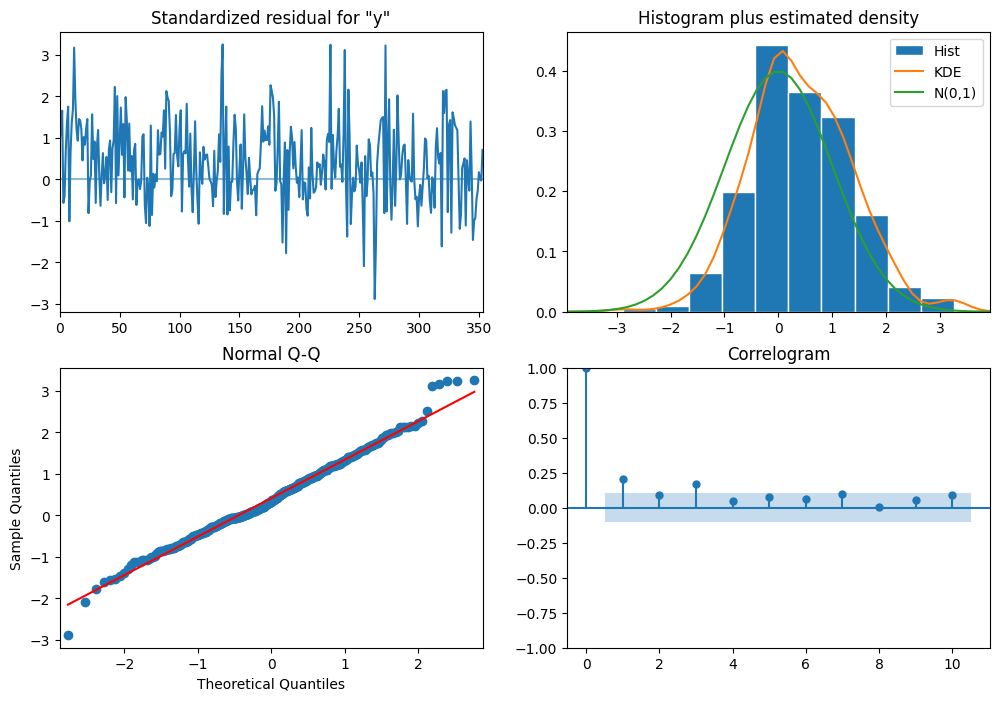

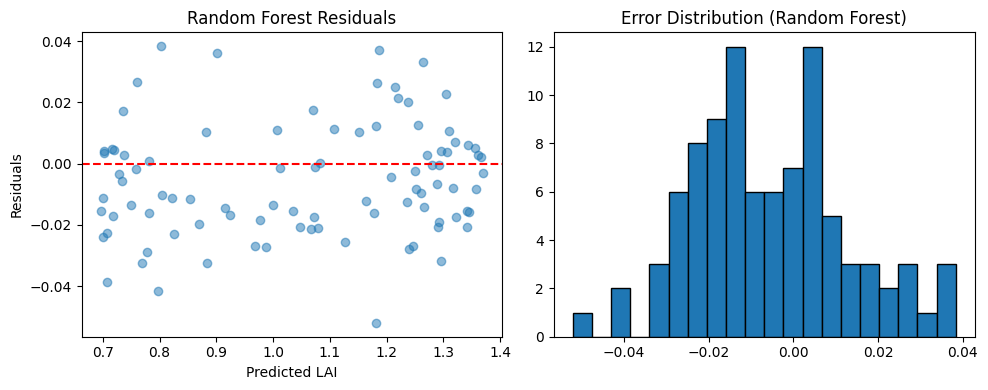

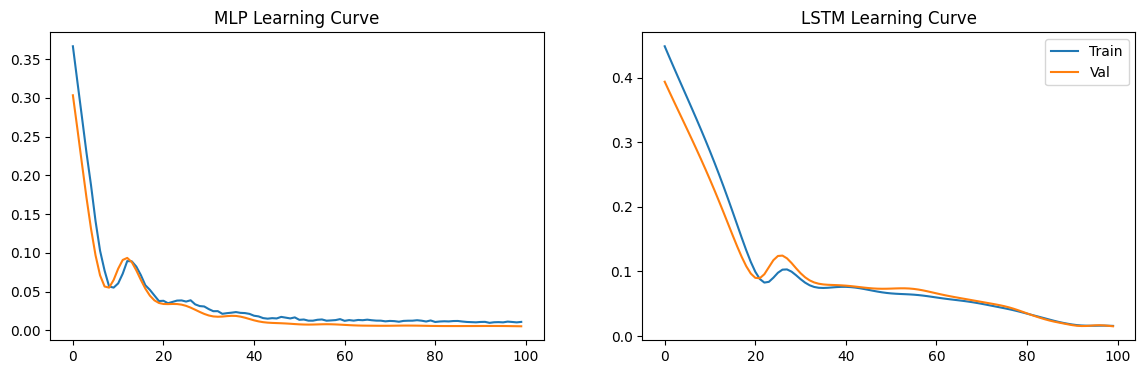

In [129]:
# model diagnostic
def plot_learning_curves(train_losses, val_losses, model_name):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example: During LSTM training, append loss to lists
# (You would run this inside your training loop)
# train_losses.append(loss.item())
# val_losses.append(val_loss.item())
# Check residuals for the SARIMAX model
sarimax_res.plot_diagnostics(figsize=(12, 8))
plt.show()

def plot_residuals(y_true, y_pred, model_name):
    residuals = np.array(y_true) - np.array(y_pred)
    plt.figure(figsize=(10, 4))
    
    # Residual Scatter
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{model_name} Residuals')
    plt.xlabel('Predicted LAI')
    plt.ylabel('Residuals')
    
    # Error Distribution
    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=20, edgecolor='black')
    plt.title('Error Distribution (Random Forest)')
    
    plt.tight_layout()
    plt.show()

# Run for RF
plot_residuals(y_test_lag, rf_model.predict(X_test_lag_sc), "Random Forest")

# Learning Curves
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(mlp_train_loss, label='Train'); ax[0].plot(mlp_val_loss, label='Val'); ax[0].set_title('MLP Learning Curve')
ax[1].plot(lstm_train_loss, label='Train'); ax[1].plot(lstm_val_loss, label='Val'); ax[1].set_title('LSTM Learning Curve')
plt.legend(); plt.show()

Performance Summary:
         R2      RMSE       MAE          Model Horizon
2  0.970897  0.038648  0.028811  Random Forest  1-Week
0  0.965016  0.042373  0.036653        SARIMAX  1-Week
4  0.954398  0.048378  0.036342            MLP  1-Week
6  0.925522  0.061826  0.048254           LSTM  1-Week
1  0.972242  0.038099  0.031751        SARIMAX  4-Week
3  0.945514  0.053379  0.040857  Random Forest  4-Week
5  0.938339  0.056784  0.043448            MLP  4-Week
7  0.919436  0.064907  0.050400           LSTM  4-Week


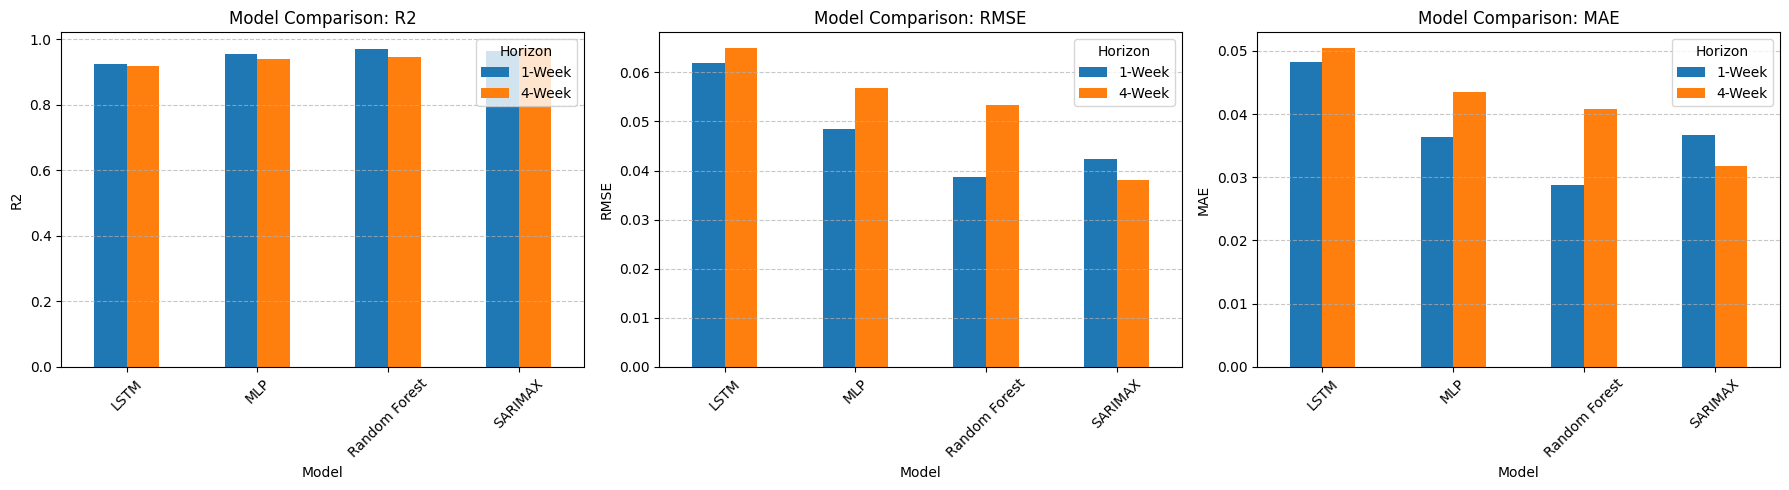

In [176]:
# ==========================================
# Evaluation and Plotting for different horizons
# ==========================================
def get_forecast(model, name, start_idx, horizon):
    
    preds_raw = []

    # --- RF and MLP Logic (Flattened Lags) ---
    if name in ['Random Forest', 'MLP']:

        current_input = X_test_lag_sc[start_idx].copy()

        for h in range(horizon):

            if name == 'Random Forest':
                p_raw = model.predict(current_input.reshape(1, -1))[0]

            else:  # MLP
                model.eval()
                with torch.no_grad():
                    p_scaled = model(
                        torch.tensor(current_input, dtype=torch.float32).unsqueeze(0)
                    ).item()
                p_raw = scaler_y.inverse_transform([[p_scaled]])[0][0]

            preds_raw.append(p_raw)

            if h < horizon - 1:
                next_row = X_test_lag_sc[start_idx + h + 1].copy()

                # Update Y-lags recursively
                for lag_rank, col_idx in enumerate(lag_y_indices):
                    if len(preds_raw) > lag_rank:
                        val = scaler_y.transform([[preds_raw[-(lag_rank + 1)]]])[0][0]
                        next_row[col_idx] = val

                current_input = next_row

    # --- LSTM Logic (3D Sequences) ---
    elif name == 'LSTM':

        current_seq = torch.tensor(
            X_test_t_lstm[start_idx], dtype=torch.float32
        ).unsqueeze(0)

        for h in range(horizon):
            model.eval()
            with torch.no_grad():
                p_scaled = model(current_seq).item()

            preds_raw.append(
                scaler_y.inverse_transform([[p_scaled]])[0][0]
            )

            if h < horizon - 1:
                new_seq = current_seq.clone()
                new_seq[0, :-1, :] = current_seq[0, 1:, :]

                next_exog = torch.tensor(
                    X_raw_sc[test_start_idx + start_idx + h + 1],
                    dtype=torch.float32
                )
                new_seq[0, -1, :] = next_exog
                current_seq = new_seq

    # --- SARIMAX / ARIMAX Logic (FIXED) ---
    elif name == 'SARIMAX':

        exog_future = X_test_df.iloc[start_idx : start_idx + horizon]

        fc = model.get_forecast(
            steps=horizon,
            exog=exog_future
        )

        preds_raw = fc.predicted_mean.values.tolist()

    return preds_raw


def calculate_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

def plot_comparison(results_df):
    metrics = ['R2', 'RMSE', 'MAE']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        # Pivot data for plotting
        plot_data = results_df.pivot(index='Model', columns='Horizon', values=metric)
        plot_data.plot(kind='bar', ax=axes[i], rot=45)
        axes[i].set_title(f'Model Comparison: {metric}')
        axes[i].set_ylabel(metric)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        if metric == 'R2':
            axes[i].set_ylim(bottom=0) # Focus on positive R2
            
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. Evaluation Logic
# ==========================================

# Dictionary to store performance
performance_data = []

# Assuming models are trained: sarimax_res, rf_model, mlp_model, lstm_model
# and data is ready: X_test_lag_sc, X_test_t_lstm, y_test_lag, scaler_y, lag_y_indices

model_list = {
    'SARIMAX': arima_res,
    'Random Forest': rf_model,
    'MLP': mlp_model,
    'LSTM': lstm_model
}

for name, model in model_list.items():
    preds_1wk = []
    preds_4wk = []
    actuals_1wk = []
    actuals_4wk = []

    # Iterate through test set to generate forecasts
    # We stop 4 weeks before the end to allow for a full 4-week horizon
    for i in range(len(y_test_lag) - 4):
        # get_forecast is the recursive function defined in previous steps
        forecasts = get_forecast(model, name, i, 4) 
        
        preds_1wk.append(forecasts[0])
        preds_4wk.append(forecasts[3])
        actuals_1wk.append(y_test_lag[i])
        actuals_4wk.append(y_test_lag[i + 3])

    # Calculate 1-Week Metrics
    m1 = calculate_metrics(actuals_1wk, preds_1wk)
    m1.update({'Model': name, 'Horizon': '1-Week'})
    performance_data.append(m1)

    # Calculate 4-Week Metrics
    m4 = calculate_metrics(actuals_4wk, preds_4wk)
    m4.update({'Model': name, 'Horizon': '4-Week'})
    performance_data.append(m4)

# Convert to DataFrame
df_perf = pd.DataFrame(performance_data)

# Print Summary Table
print("Performance Summary:")
print(df_perf.sort_values(by=['Horizon', 'R2'], ascending=[True, False]))

# Generate Plots
plot_comparison(df_perf)

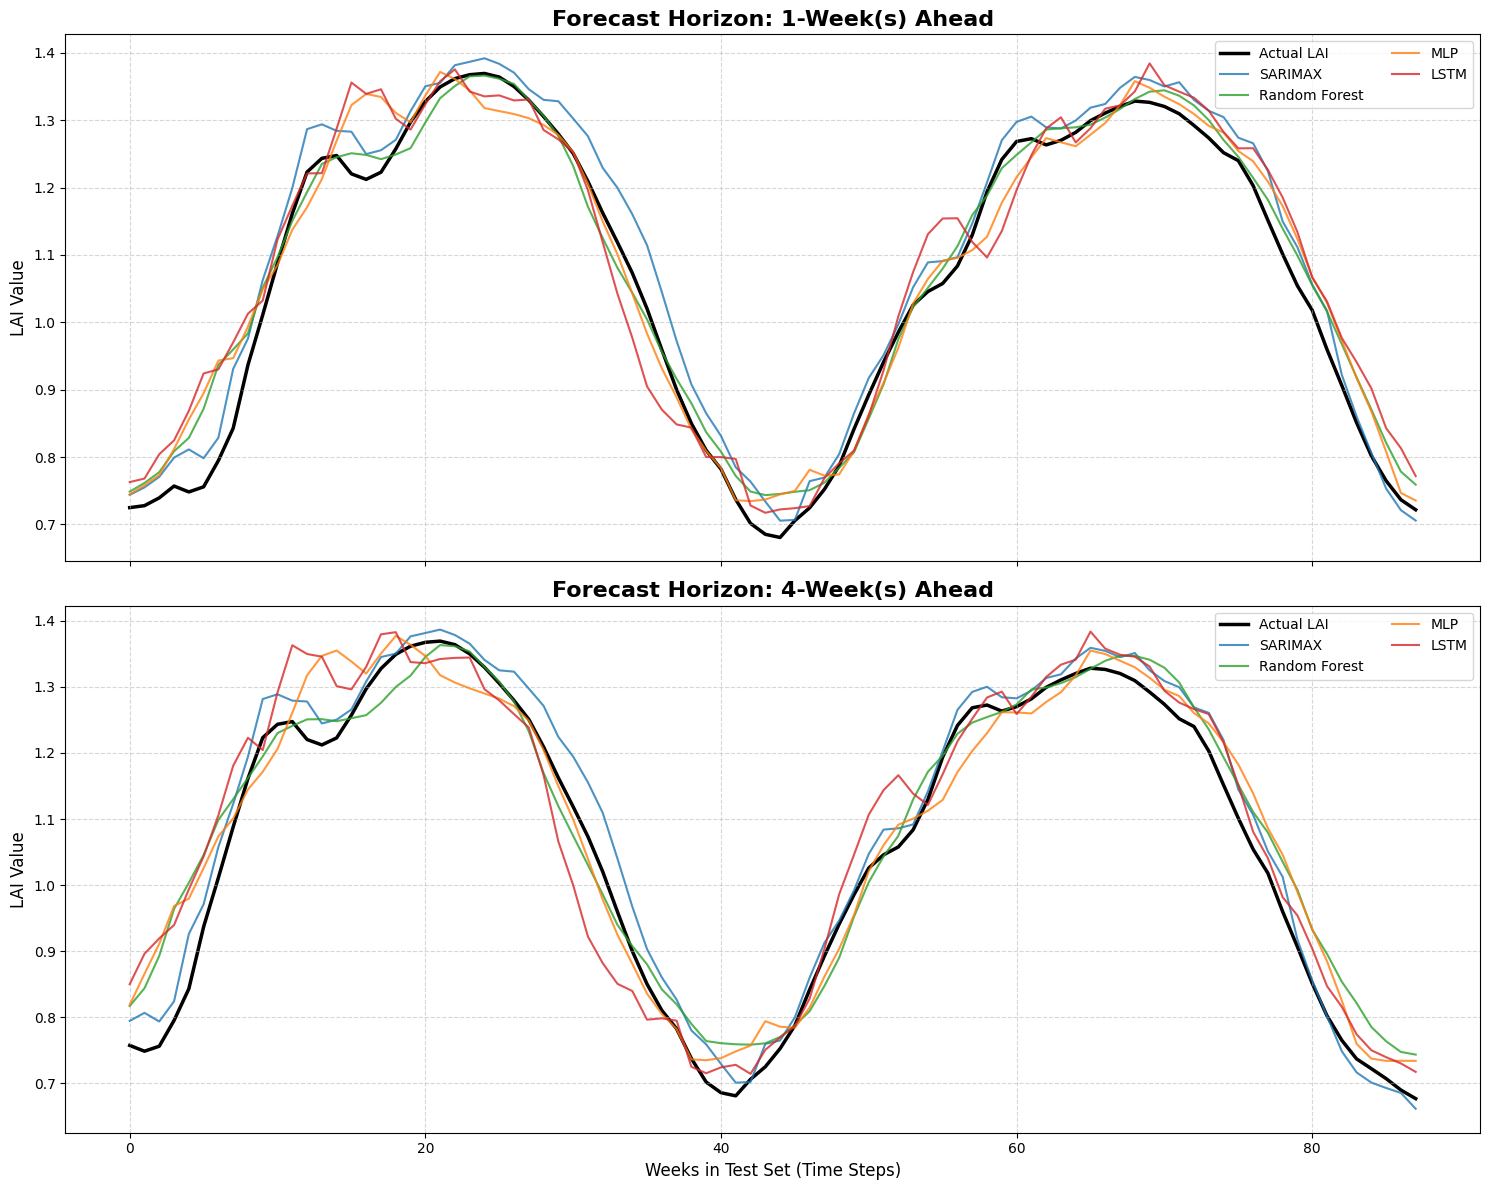

In [183]:
def plot_combined_horizons(model_list, y_true, horizons=[1, 4]):
    """
    Plots all model predictions on a single figure with two panels (one per horizon).
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    # Standard colors for consistency
    colors = {
        'SARIMAX': '#1f77b4',       # Blue
        'Random Forest': '#2ca02c', # Green
        'MLP': '#ff7f0e',           # Orange
        'LSTM': '#d62728'           # Red
    }
    
    # Calculate common limit to ensure alignment
    limit = len(y_true) - 4 

    for idx, h in enumerate(horizons):
        ax = axes[idx]
        
        # 1. Plot the Actual Ground Truth
        # We align by shifting the actuals based on the horizon
        actual_indices = np.arange(limit) + (h - 1)
        ax.plot(y_true[actual_indices], color='black', label='Actual LAI', linewidth=2.5, zorder=1)
        
        # 2. Plot each model's prediction for this horizon
        for name, model in model_list.items():
            preds = []
            for i in range(limit):
                # Using your existing get_forecast recursive logic
                f = get_forecast(model, name, i, h)
                preds.append(f[-1]) # Grab the specific H-week ahead point
            
            ax.plot(preds, label=f'{name}', color=colors.get(name), alpha=0.8, linewidth=1.5)
        
        # Formatting
        ax.set_title(f'Forecast Horizon: {h}-Week(s) Ahead', fontsize=16, fontweight='bold')
        ax.set_ylabel('LAI Value', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc='upper right', ncol=2)

    plt.xlabel('Weeks in Test Set (Time Steps)', fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Execution ---
# Convert y_test_lag to numpy for consistent indexing
y_true_np = np.array(y_test_lag)
plot_combined_horizons(model_list, y_true_np)